In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from venn_abers import VennAbersCalibrator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, brier_score_loss, f1_score

from metrics import expected_calibration_error

In [2]:
#loading data
df = pd.read_csv(r'./data/diabetes_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [3]:
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [4]:
df

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,Female,33.0,Wyoming,0,0,0,0,1,0,0,never,21.21,6.5,90,0
99996,2016,Female,80.0,Wyoming,0,1,0,0,0,0,0,No Info,36.66,5.7,100,0
99997,2018,Male,46.0,Wyoming,0,1,0,0,0,0,0,ever,36.12,6.2,158,0
99998,2018,Female,51.0,Wyoming,1,0,0,0,0,0,0,not current,29.29,6.0,155,0


In [5]:
df_smoke_ratios = df.groupby('smoking_history')['diabetes'].value_counts().unstack()
df_smoke_ratios
df_smoke_ratios['ratio'] = df_smoke_ratios[1] / df_smoke_ratios[0]
df_smoke_ratios

diabetes,0,1,ratio
smoking_history,,,
No Info,34362,1454,0.042314
current,8338,948,0.113696
ever,3532,472,0.133635
former,7762,1590,0.204844
never,31749,3346,0.105389
not current,5757,690,0.119854


In [6]:
# Data Preprocessing
nan_summary = df.isna().sum()
print("NaN count before processing:\n", nan_summary[nan_summary > 0])

# Separate numeric and categorical 
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

encoder = OneHotEncoder()
# df['gender'] = encoder.fit_transform(df[['gender']])
df['gender_female'] = df['gender'] == 'Female'

for col in set(df['smoking_history']):
    df['smoking_'+col] = 1*(df['smoking_history']==col)

# df['smoking_history'] = encoder.fit_transform(df['smoking_history'])
df=df.drop(columns=['location', 'smoking_history', 'gender'])

# reorder columns
col = 'diabetes'
df = df[[c for c in df.columns if c != col] + [col]]
df

NaN count before processing:
 Series([], dtype: int64)


,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,gender_female,smoking_No Info,smoking_current,smoking_not current,smoking_former,smoking_ever,smoking_never,diabetes
0,2020,32.0,0,0,0,0,1,0,0,27.32,5.0,100,True,0,0,0,0,0,1,0
1,2015,29.0,0,1,0,0,0,0,0,19.95,5.0,90,True,0,0,0,0,0,1,0
2,2015,18.0,0,0,0,0,1,0,0,23.76,4.8,160,False,0,0,0,0,0,1,0
3,2015,41.0,0,0,1,0,0,0,0,27.32,4.0,159,False,0,0,0,0,0,1,0
4,2016,52.0,1,0,0,0,0,0,0,23.75,6.5,90,True,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,33.0,0,0,0,0,1,0,0,21.21,6.5,90,True,0,0,0,0,0,1,0
99996,2016,80.0,0,1,0,0,0,0,0,36.66,5.7,100,True,1,0,0,0,0,0,0
99997,2018,46.0,0,1,0,0,0,0,0,36.12,6.2,158,False,0,0,0,0,1,0,0
99998,2018,51.0,1,0,0,0,0,0,0,29.29,6.0,155,True,0,0,1,0,0,0,0


<Axes: >

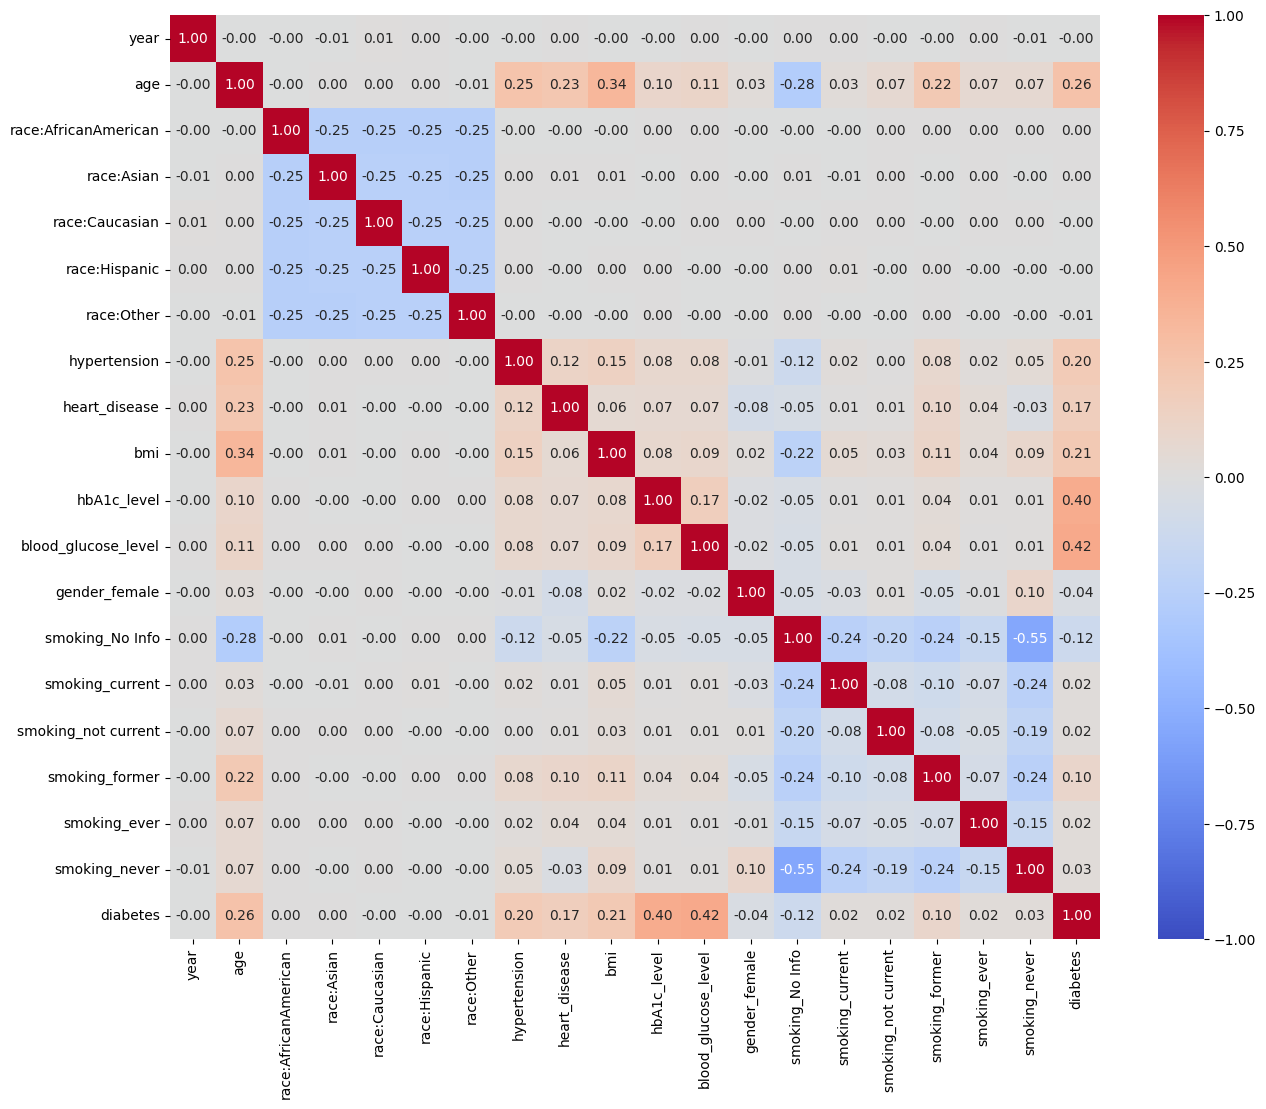

In [7]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

<Axes: >

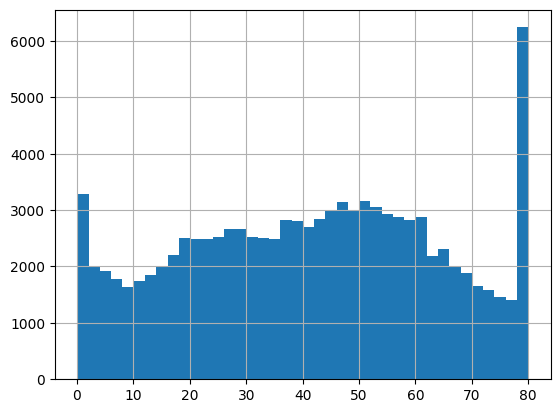

In [8]:
df.age.hist(bins=40)

<Axes: xlabel='diabetes', ylabel='count'>

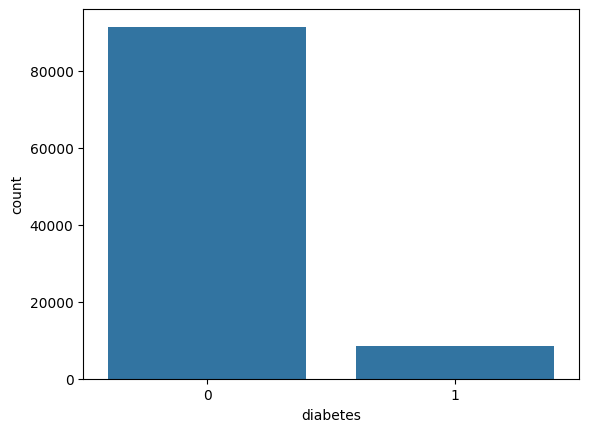

In [9]:
sns.countplot(data=df, x='diabetes')

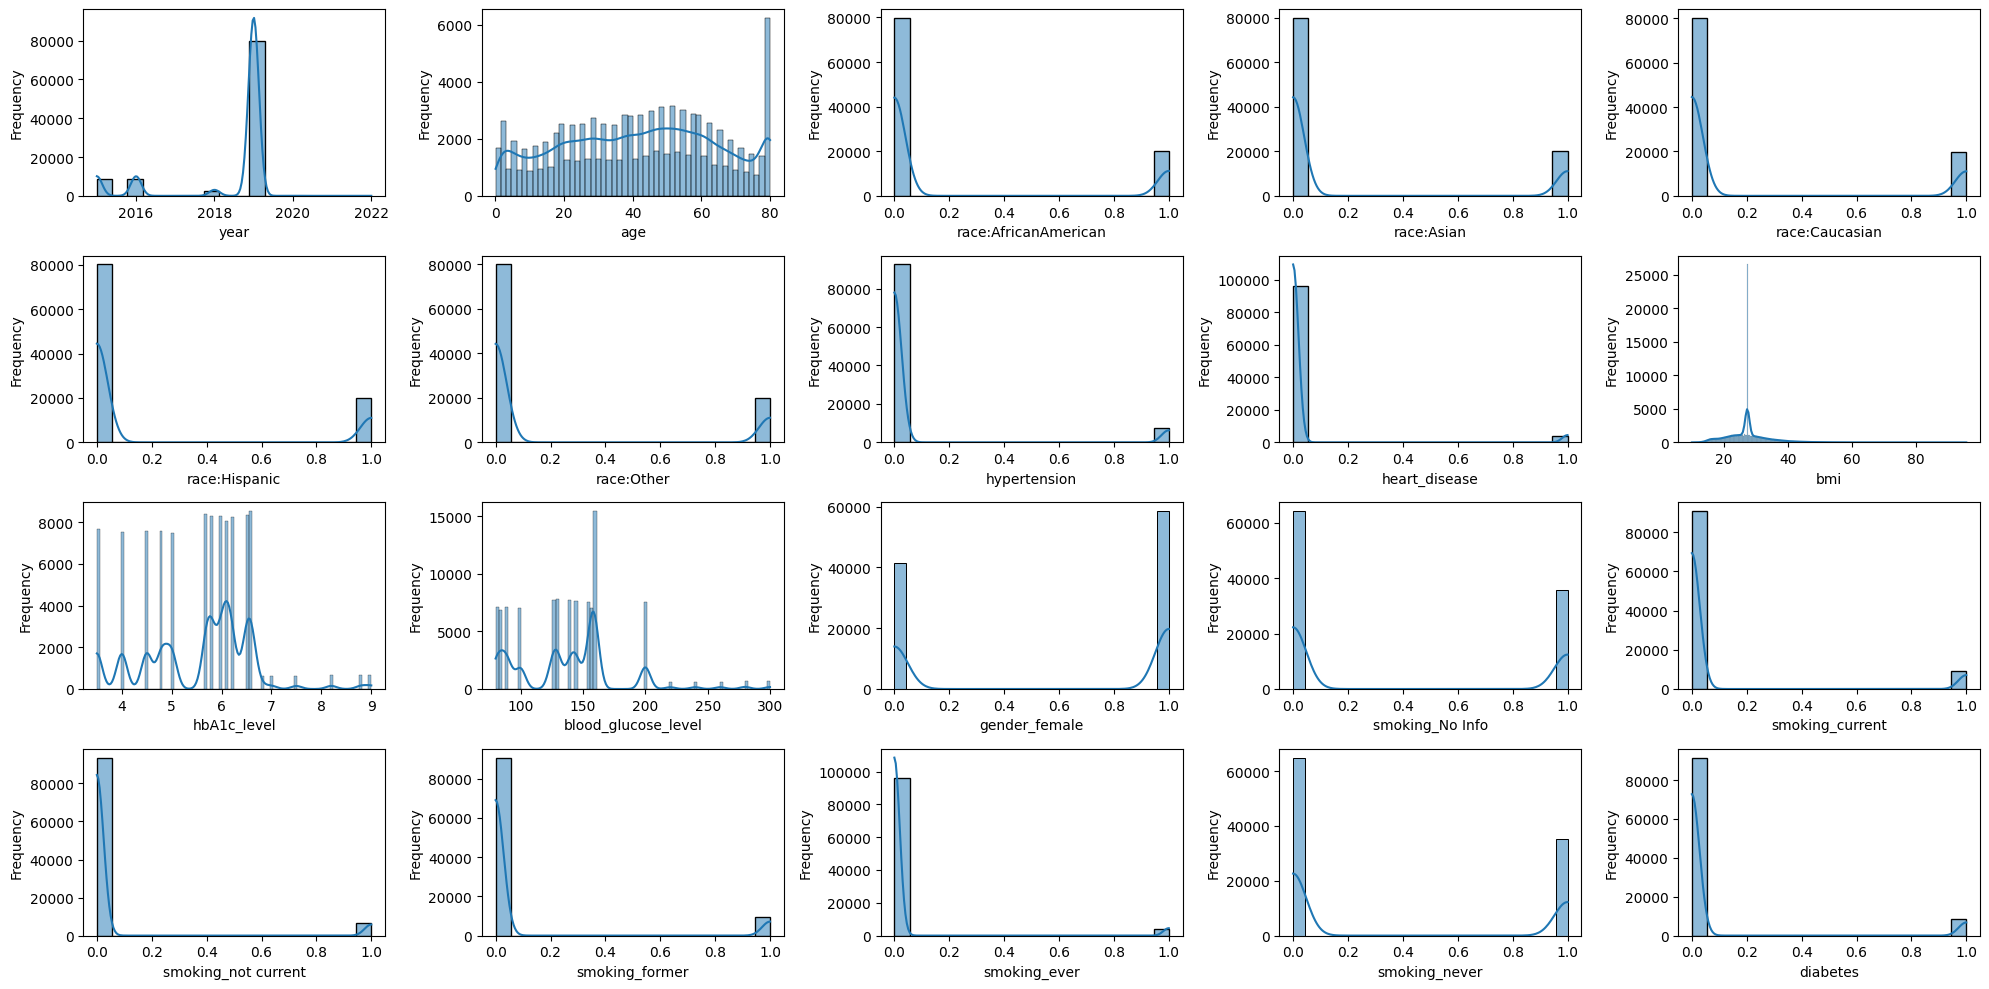

In [10]:
#Exploratory Data Analysis (EDA)

plt.figure(figsize=(20, 10))
plotnumber = 1
for column in df:
    if plotnumber <= 30:  
        ax = plt.subplot(4, 5, plotnumber)  
        sns.histplot(df[column], kde=True)  
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
    plotnumber += 1

plt.tight_layout() 
plt.show()


In [11]:
# creating features and label 

X = df.drop('diabetes', axis = 1)
y = df['diabetes']

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.10 , random_state = 0)
X_train, X_cal, y_train, y_cal = train_test_split(X_train_temp, y_train_temp, test_size = 0.20 , random_state = 0)

In [12]:
#logistic Regression

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(class_weight=None)
log_reg.fit(X_train, y_train)

# model predictions

y_pred = log_reg.predict(X_test)


# accuracy score

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_train, log_reg.predict(X_train)))  # Train accuracy
rf_acc = accuracy_score(y_test, log_reg.predict(X_test))  # Test accuracy
print(rf_acc)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, log_reg.predict(X_test)))

0.9599027777777778
0.9596
[[9036   81]
 [ 323  560]]
0.7349081364829396


c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rf = RandomForestClassifier(random_state=42, n_estimators=1000, n_jobs=-1, class_weight=None) 

# Train the model
rf.fit(X_train, y_train)

# Model predictions
y_pred = rf.predict(X_test)

# Accuracy score
print(accuracy_score(y_train, rf.predict(X_train)))  # Train accuracy
rf_acc = accuracy_score(y_test, rf.predict(X_test))  # Test accuracy
print(rf_acc)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, rf.predict(X_test)))

0.9998472222222222
0.9718
[[9102   15]
 [ 267  616]]
0.8137384412153237


In [14]:
# from sklearn.svm import SVC

# scaler = StandardScaler()
# X_cal = scaler.fit_transform(X_cal)
# X_test = scaler.transform(X_test)

# svm_clf = SVC(kernel='linear', C=1.0, random_state=42)# , probability=True)


# # Train the model
# svm_clf.fit(X_train, y_train)

# # Model predictions
# y_pred = svm_clf.predict(X_test)

# # Accuracy score
# print(accuracy_score(y_train, rf.predict(X_train)))  # Train accuracy
# rf_acc = accuracy_score(y_test, rf.predict(X_test))  # Test accuracy
# print(rf_acc)
# print(confusion_matrix(y_test, y_pred))


In [15]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()# , probability=True)


# Train the model
nb_clf.fit(X_train, y_train)

# Model predictions
y_pred = nb_clf.predict(X_test)

# Accuracy score
print(accuracy_score(y_train, nb_clf.predict(X_train)))  # Train accuracy
acc = accuracy_score(y_test, nb_clf.predict(X_test))  # Test accuracy
print(acc)
print(confusion_matrix(y_test, y_pred))

0.9006666666666666
0.901
[[8406  711]
 [ 279  604]]


In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


# Initialize XGBoost classifier
xgb_clf = XGBClassifier(objective='binary:logistic',  # Use 'multi:softmax' for multiclass
                         eval_metric='logloss',       # Evaluation metric
                         use_label_encoder=False,     # Avoid warnings in new versions
                         random_state=42,
                         n_jobs=-1
                         )

# Train the model
xgb_clf.fit(X_train, y_train)

# Model predictions
y_pred = xgb_clf.predict(X_test)

# Accuracy score
print(accuracy_score(y_train, xgb_clf.predict(X_train)))  # Train accuracy
xgb_acc = accuracy_score(y_test, y_pred)  # Test accuracy
print(xgb_acc)

# Confusion matrix
print(confusion_matrix(y_test, y_pred))


c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:03:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.9769861111111111
0.9698
[[9076   41]
 [ 261  622]]


In [31]:
from sklearn.ensemble import StackingClassifier

stack_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, n_estimators=1000, n_jobs=-1, class_weight=None)),
        ('lr', LogisticRegression()), 
    ], 
    final_estimator=LogisticRegression()
)

stack_clf.fit(X_train, y_train)

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=1000,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [33]:
#Sigmoid (Platt Scaling)- Calibration method
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.frozen import FrozenEstimator
import matplotlib.pyplot as plt
import numpy as np

METRICS = []

def plot_calibration_curve(classifier, X_cal, y_cal, X_test, y_test, method='sigmoid', n_bins=10, cv='prefit'):
    """
    Apply calibration to a classifier using Sigmoid (Platt Scaling) and plot the calibration curve.
    
    Parameters:
    - classifier: Base classifier (e.g., LogisticRegression, RandomForestClassifier)
    - X_cal, y_cal: Calibration data
    - X_test, y_test: Test data
    - method: 'sigmoid' or 'isotonic' for scikitlearn-based calibration
    - n_bins: Number of bins for the calibration curve
    """
    # Apply calibration
    if method=="venn_abers":
        # calibrated_clf = VennAbersCalibrator(estimator=classifier, inductive=True, cal_size=0.2, random_state=101)
        # y_prob = calibrated_clf.predict_proba(X_test)

        p_cal = classifier.predict_proba(X_cal)
        p_test = classifier.predict_proba(X_test)
        va = VennAbersCalibrator()
        y_prob = va.predict_proba(p_cal=p_cal, y_cal=y_cal.values.reshape(-1, 1), p_test=p_test)[:, 1]
        y_pred = y_prob > 0.5
    else:
        calibrated_clf = CalibratedClassifierCV(FrozenEstimator(classifier), method=method, cv=cv)
        calibrated_clf.fit(X_cal, y_cal)
        y_prob = calibrated_clf.predict_proba(X_test)[:, 1]
        y_pred = calibrated_clf.predict(X_test)
    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=n_bins)

    # Metrics
    classifier_name = classifier.__class__.__name__
    METRICS.append({
        'classifier': classifier_name,
        'brier_loss': brier_score_loss(y_test, y_prob),
        'log_loss': log_loss(y_test, y_prob),
        'ECE': expected_calibration_error(y_test, y_prob),
        'F1_score': f1_score(y_test, y_pred),
        'calibration_method': method,
    })

    # Predict probabilities
    y_prob = classifier.predict_proba(X_test)[:, 1]
    y_pred = classifier.predict(X_test)

    # Metrics
    classifier_name = classifier.__class__.__name__
    METRICS.append({
        'classifier': classifier_name,
        'brier_loss': brier_score_loss(y_test, y_prob),
        'log_loss': log_loss(y_test, y_prob),
        'ECE': expected_calibration_error(y_test, y_prob),
        'F1_score': f1_score(y_test, y_pred),
        'calibration_method': 'uncalibrated',
    })
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=f'{classifier_name} ({method.capitalize()})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f"Calibration Curve ({method.capitalize()})")
    plt.legend()
    plt.show()

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


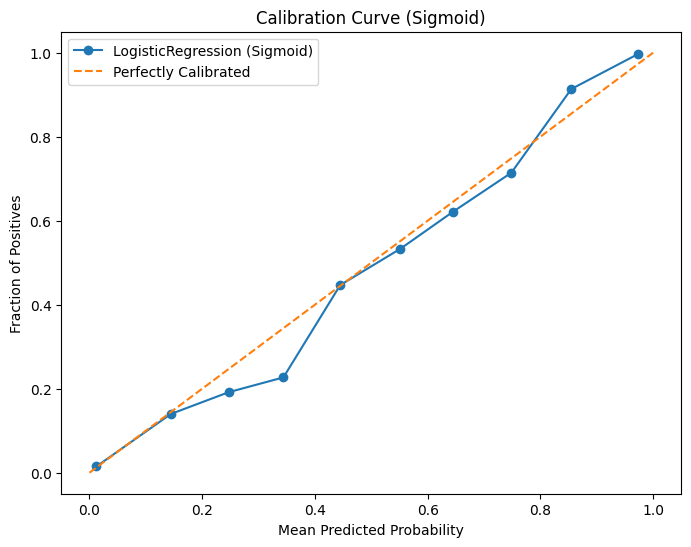

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


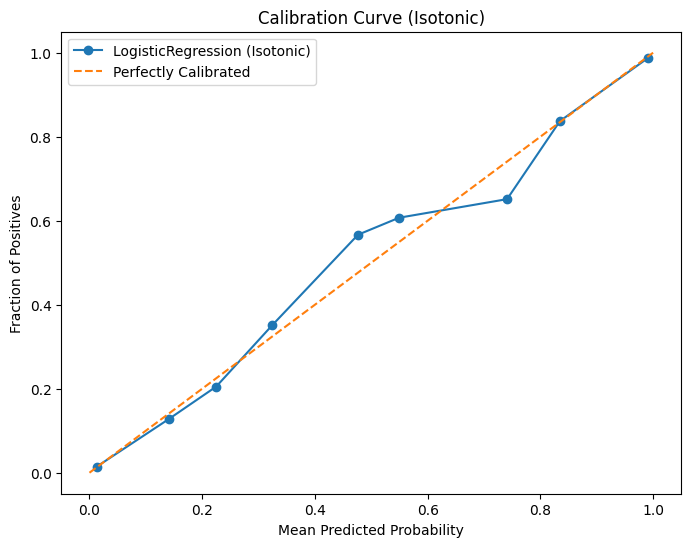

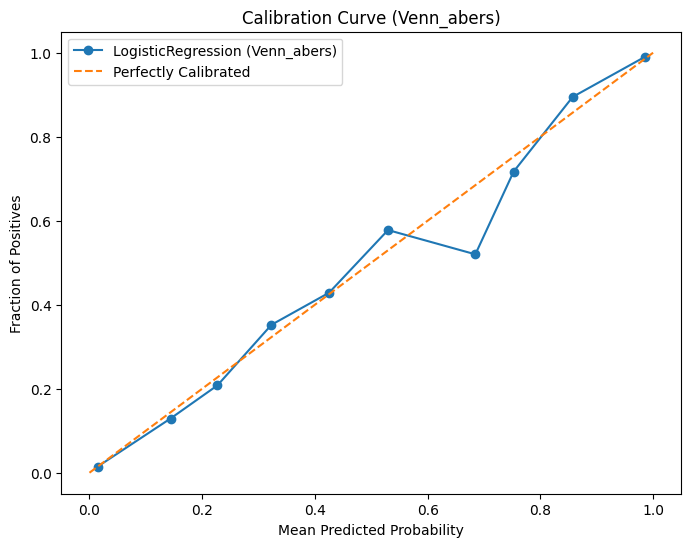

In [34]:
#Logistic Regression
# Plot calibration curve using Sigmoid (Platt Scaling)+ Isotonic
plot_calibration_curve(log_reg, X_cal, y_cal, X_test, y_test, method='sigmoid')
plot_calibration_curve(log_reg, X_cal, y_cal, X_test, y_test, method='isotonic')
plot_calibration_curve(log_reg, X_cal, y_cal, X_test, y_test, method='venn_abers')

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


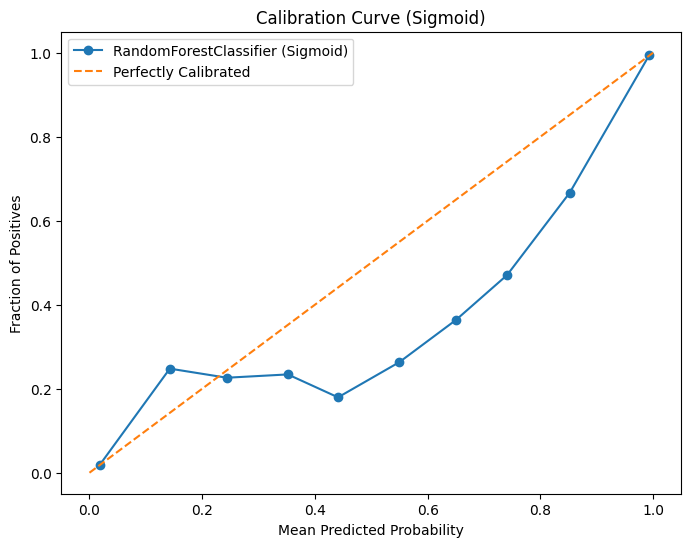

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


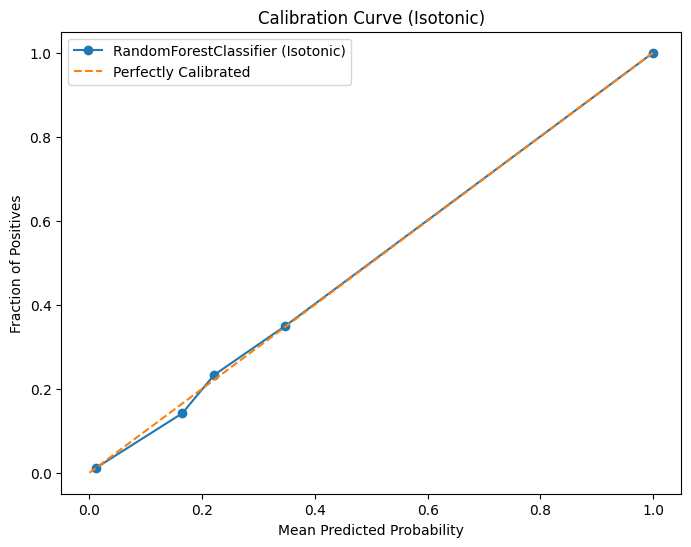

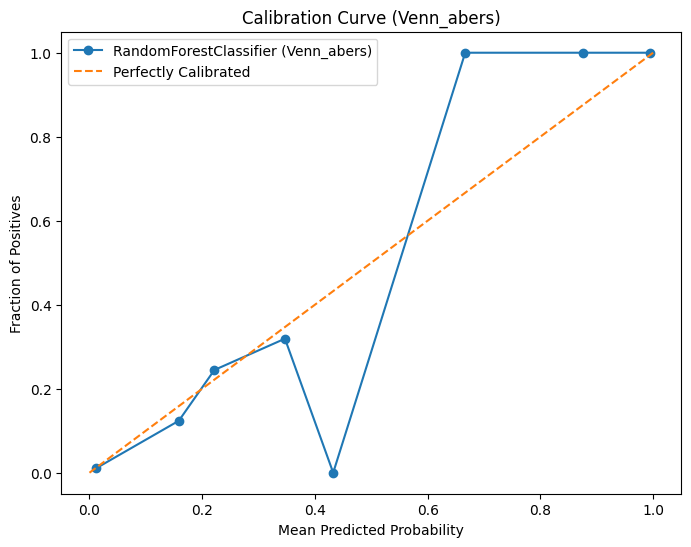

In [35]:
#Random Forest 
# Plot calibration curve using Sigmoid (Platt Scaling) + Isotonic
plot_calibration_curve(rf, X_cal, y_cal, X_test, y_test, method='sigmoid')
plot_calibration_curve(rf, X_cal, y_cal, X_test, y_test, method='isotonic')
plot_calibration_curve(rf, X_cal, y_cal, X_test, y_test, method='venn_abers')

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


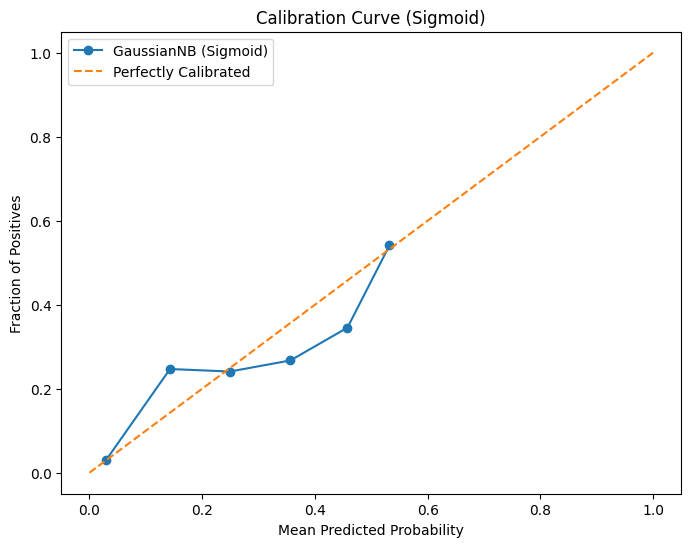

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


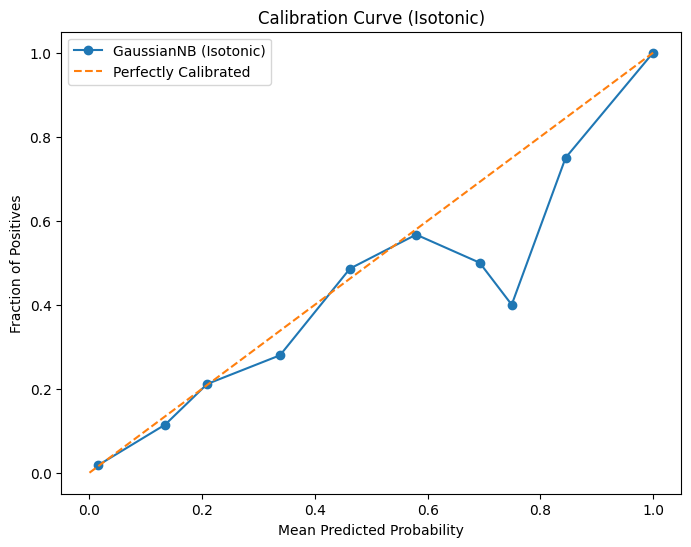

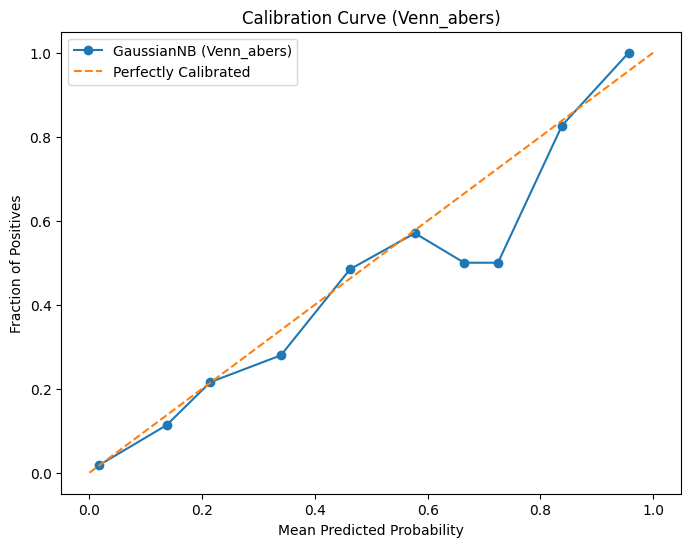

In [36]:
#NB
# Plot calibration curve using Sigmoid (Platt Scaling) + Isotonic
plot_calibration_curve(nb_clf, X_cal, y_cal, X_test, y_test, method='sigmoid')
plot_calibration_curve(nb_clf, X_cal, y_cal, X_test, y_test, method='isotonic')
plot_calibration_curve(nb_clf, X_cal, y_cal, X_test, y_test, method='venn_abers')

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


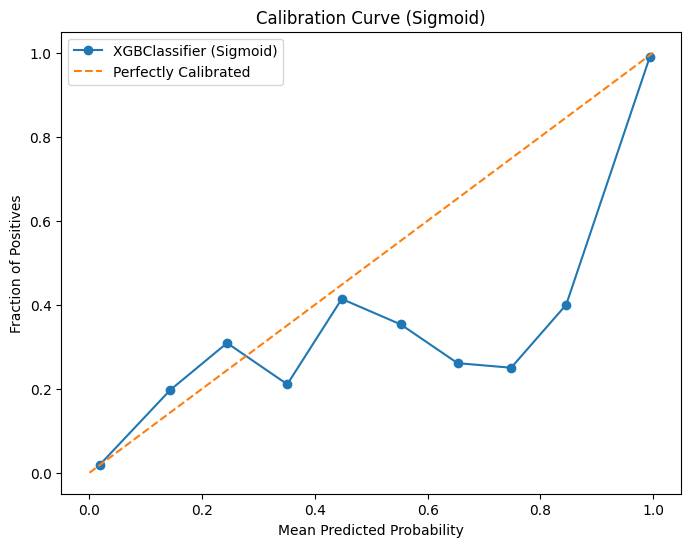

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


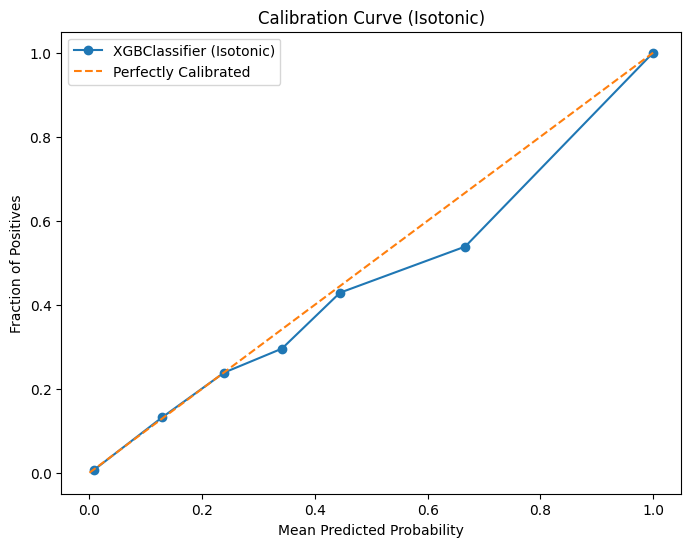

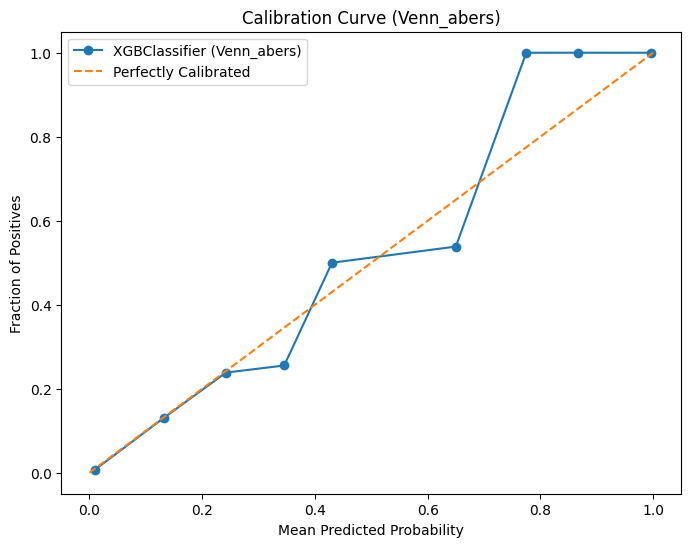

In [37]:
#XGBOOST
# Plot calibration curve using Sigmoid (Platt Scaling) + Isotonic
plot_calibration_curve(xgb_clf, X_cal, y_cal, X_test, y_test, method='sigmoid')
plot_calibration_curve(xgb_clf, X_cal, y_cal, X_test, y_test, method='isotonic')
plot_calibration_curve(xgb_clf, X_cal, y_cal, X_test, y_test, method='venn_abers')

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


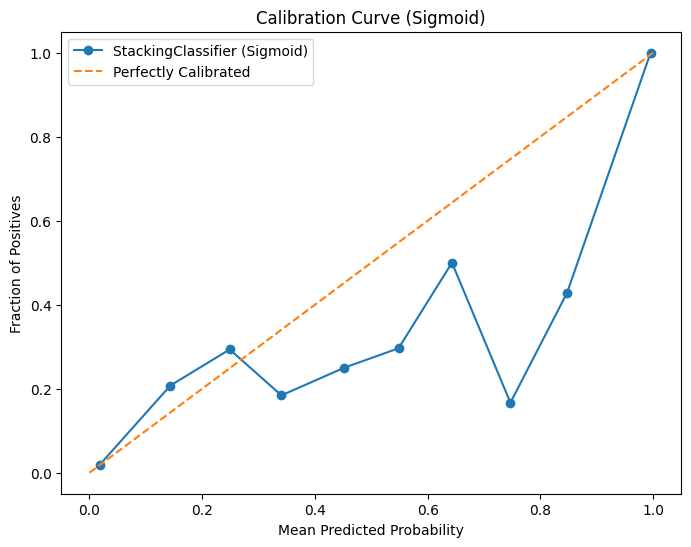

c:\Users\AsusTUF\anaconda3\envs\tru_ml_probability_calibration\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


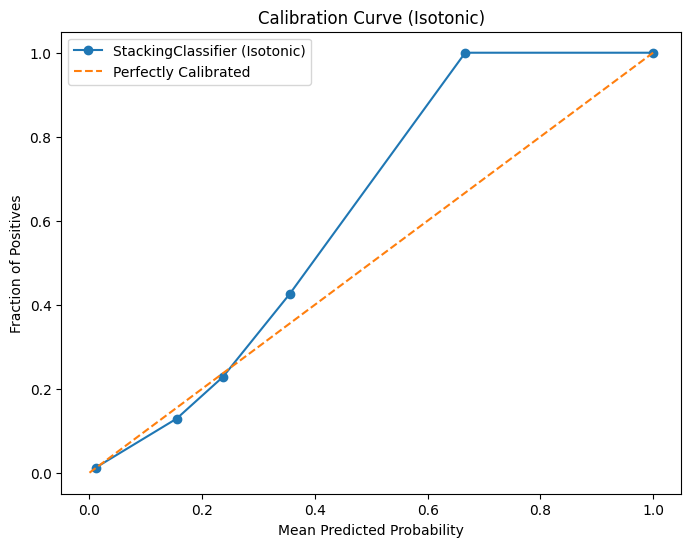

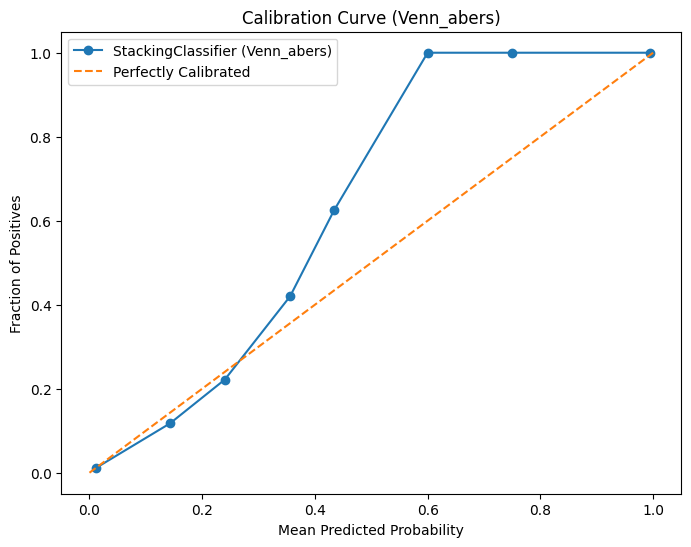

In [38]:
#XGBOOST
# Plot calibration curve using Sigmoid (Platt Scaling) + Isotonic
plot_calibration_curve(stack_clf, X_cal, y_cal, X_test, y_test, method='sigmoid')
plot_calibration_curve(stack_clf, X_cal, y_cal, X_test, y_test, method='isotonic')
plot_calibration_curve(stack_clf, X_cal, y_cal, X_test, y_test, method='venn_abers')

In [39]:
df_metrics = pd.DataFrame(METRICS).pivot_table(
    index=['calibration_method', 'classifier'],
    values=['brier_loss', 'log_loss', 'ECE', 'F1_score'],
)
df_metrics = df_metrics[['brier_loss', 'log_loss', 'ECE', 'F1_score']]
df_metrics

brier_loss  log_loss       ECE  \
calibration_method classifier                                               
isotonic           GaussianNB                0.055124  0.182624  0.008649   
                   LogisticRegression        0.032352  0.114285  0.004972   
                   RandomForestClassifier    0.023646  0.087554  0.003061   
                   StackingClassifier        0.023831  0.089059  0.003057   
                   XGBClassifier             0.023228  0.084386  0.001790   
sigmoid            GaussianNB                0.057544  0.203562  0.006097   
                   LogisticRegression        0.032265  0.114738  0.007269   
                   RandomForestClassifier    0.025255  0.100201  0.006180   
                   StackingClassifier        0.025116  0.100124  0.006000   
                   XGBClassifier             0.025647  0.101420  0.005867   
uncalibrated       GaussianNB                0.086414  0.520958  0.079982   
                   LogisticRegression        0.032236  0.114767  0.006751   
                   RandomForestClassifier    0.024309  0.100457  0.008189   
                   StackingClassifier        0.025278  0.100182  0.006288   
                   XGBClassifier             0.023800  0.083244  0.006670   
venn_abers         GaussianNB                0.055096  0.182983  0.007819   
                   LogisticRegression        0.032308  0.114515  0.003413   
                   RandomForestClassifier    0.023721  0.088004  0.004384   
                   StackingClassifier        0.023806  0.089149  0.003386   
                   XGBClassifier             0.023232  0.082228  0.003321   

                                           F1_score  
calibration_method classifier                        
isotonic           GaussianNB              0.273874  
                   LogisticRegression      0.729475  
                   RandomForestClassifier  0.809973  
                   StackingClassifier      0.810774  
                   XGBClassifier           0.812291  
sigmoid            GaussianNB              0.537892  
                   LogisticRegression      0.737117  
                   RandomForestClassifier  0.808237  
                   StackingClassifier      0.807939  
                   XGBClassifier           0.802799  
uncalibrated       GaussianNB              0.549591  
                   LogisticRegression      0.734908  
                   RandomForestClassifier  0.813738  
                   StackingClassifier      0.805096  
                   XGBClassifier           0.804657  
venn_abers         GaussianNB              0.276978  
                   LogisticRegression      0.733200  
                   RandomForestClassifier  0.809973  
                   StackingClassifier      0.810774  
                   XGBClassifier           0.812291

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_calibration_comparison(df, metric_list=['log_loss', 'brier_loss', 'ECE', 'F1_score']):
    """
    Plots grouped bar charts showing classifier performance per calibration method for each metric.
    
    Parameters:
        df (pd.DataFrame): Must contain columns: ['classifier', 'calibration_method', ...metrics]
        metric_list (list of str): Metrics to plot separately.
    """
    for metric in metric_list:
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=df,
            x='classifier',
            y=metric,
            hue='calibration_method',
            errorbar=None  # Optional: remove error bars
        )
        plt.title(f'Classifier Performance Comparison - {metric}')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.xlabel('Classifier')
        plt.xticks(rotation=45)
        plt.legend(title='Calibration Method')
        plt.tight_layout()
        plt.show()


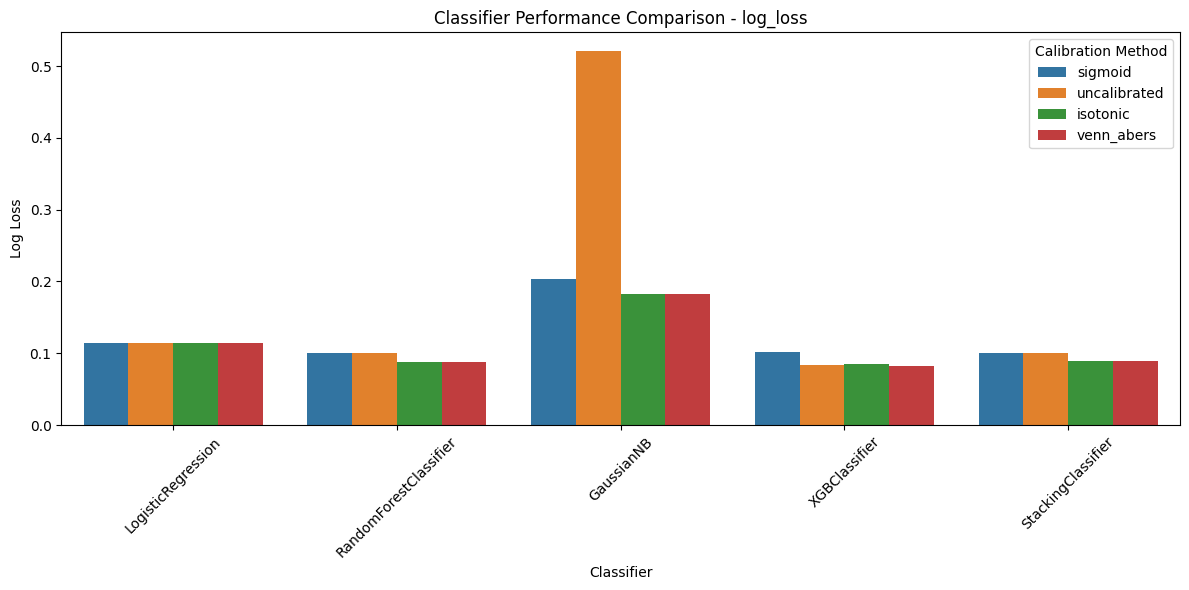

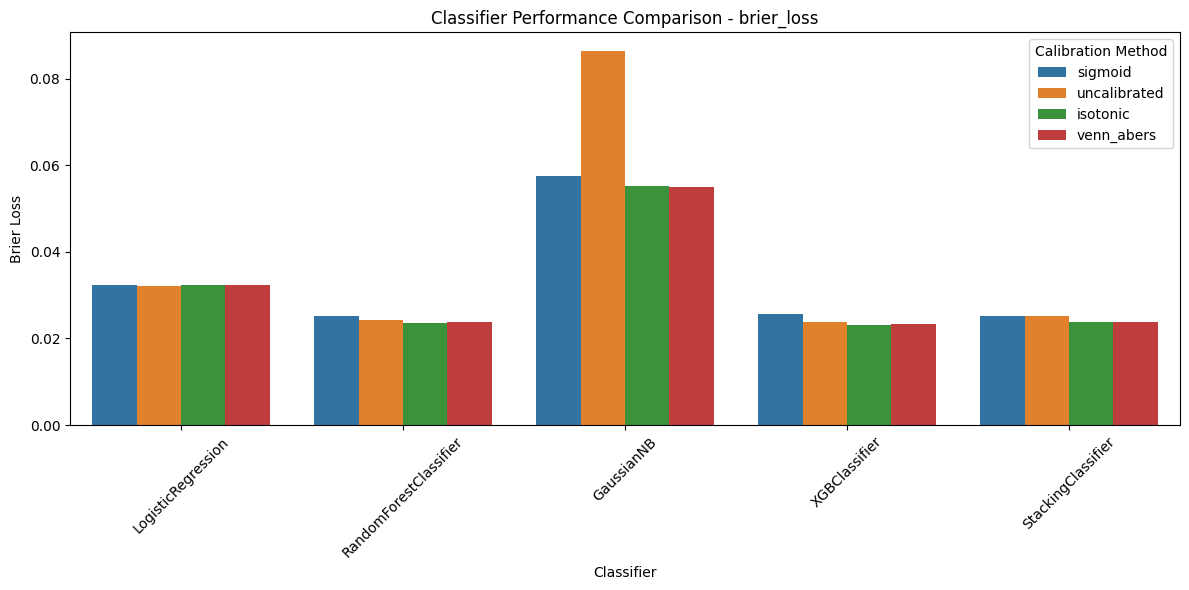

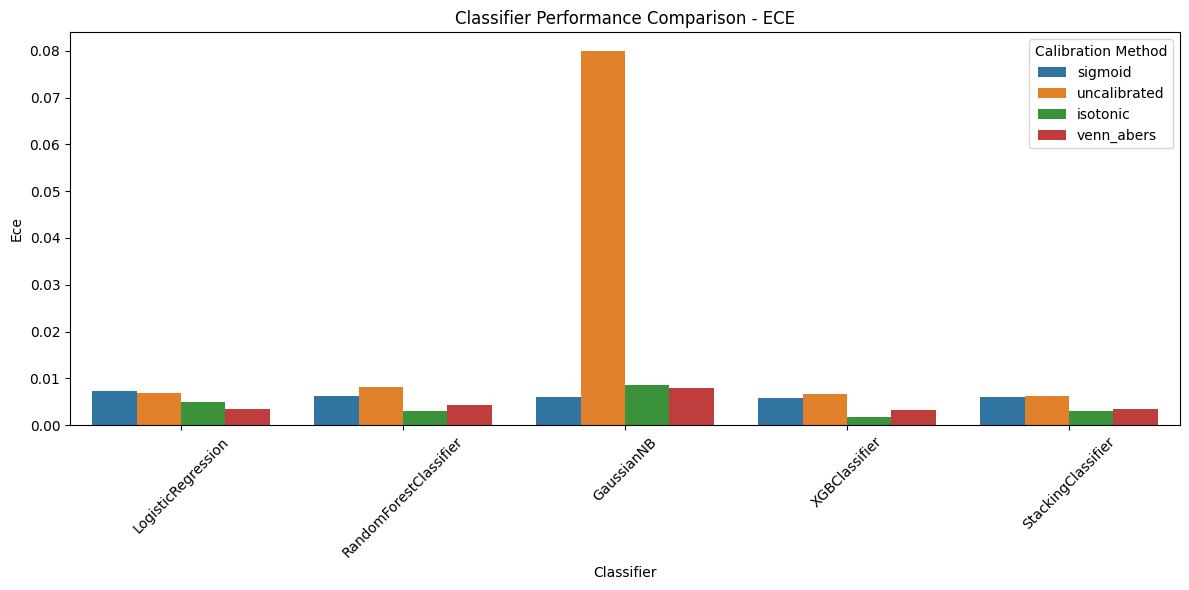

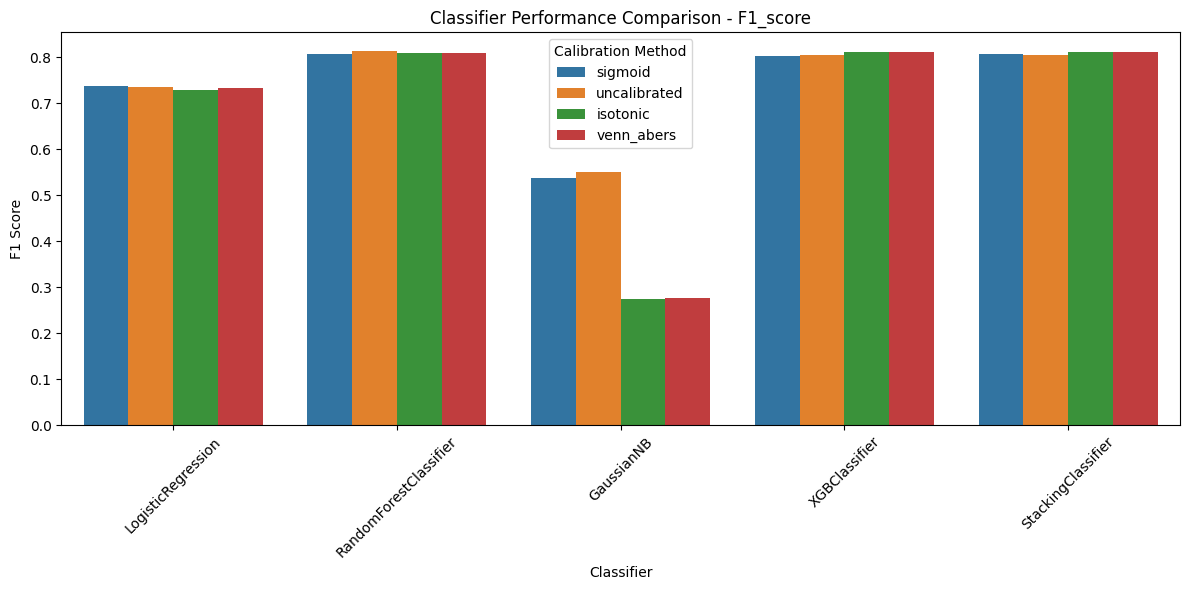

In [42]:
plot_calibration_comparison(pd.DataFrame(METRICS))